In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

import matplotlib.colors as mcolors
import copy

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


def cus_plot_img_label(X_main, lbl, cls_dict):
    X_modified = X_main.copy()  # Create a copy of the input image

    c = mask_to_categorical(lbl, n_classes=4, classes=cls_dict)
    res = np.argmax(c, axis=-1).astype(np.uint16)

    colors = {
        1: (59 / 255, 154 / 255, 251 / 255),   # Blue for mask value 1
        2: (0 / 255, 255 / 255, 61 / 255),     # Green for mask value 2
        3: (250 / 255, 220 / 255, 57 / 255),   # Yellow for mask value 3
        4: (255 / 255, 0 / 255, 23 / 255)      # Red for mask value 4
    }

    h, w = res.shape[:2]
    mask_values = np.unique(res)

    for mask_value in mask_values:
        if mask_value in colors:
            color = colors[mask_value]
            mask = res == mask_value
            X_modified[mask] = color

    return X_modified


def plot_all(img, lbl, cls_dict, img_title="ROI", lbl_title="Ground truth", cls_title="Ground truth by Classs", font_size=18, **kwargs):
    
    plot_img=cus_plot_img_label(img,lbl,cls_dict)
    
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title, fontsize=font_size)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title, fontsize=font_size)
    ac.imshow(plot_img)
    ac.set_title(cls_title, fontsize=font_size)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
transport.py (219): Blowfish has been deprecated


In [2]:
# set the number of object classes
n_classes = 4

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict


    
X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:08<00:00,  5.12it/s]


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Ground truth'}>,
 <Axes: title={'center': 'Ground truth by Classs'}>)

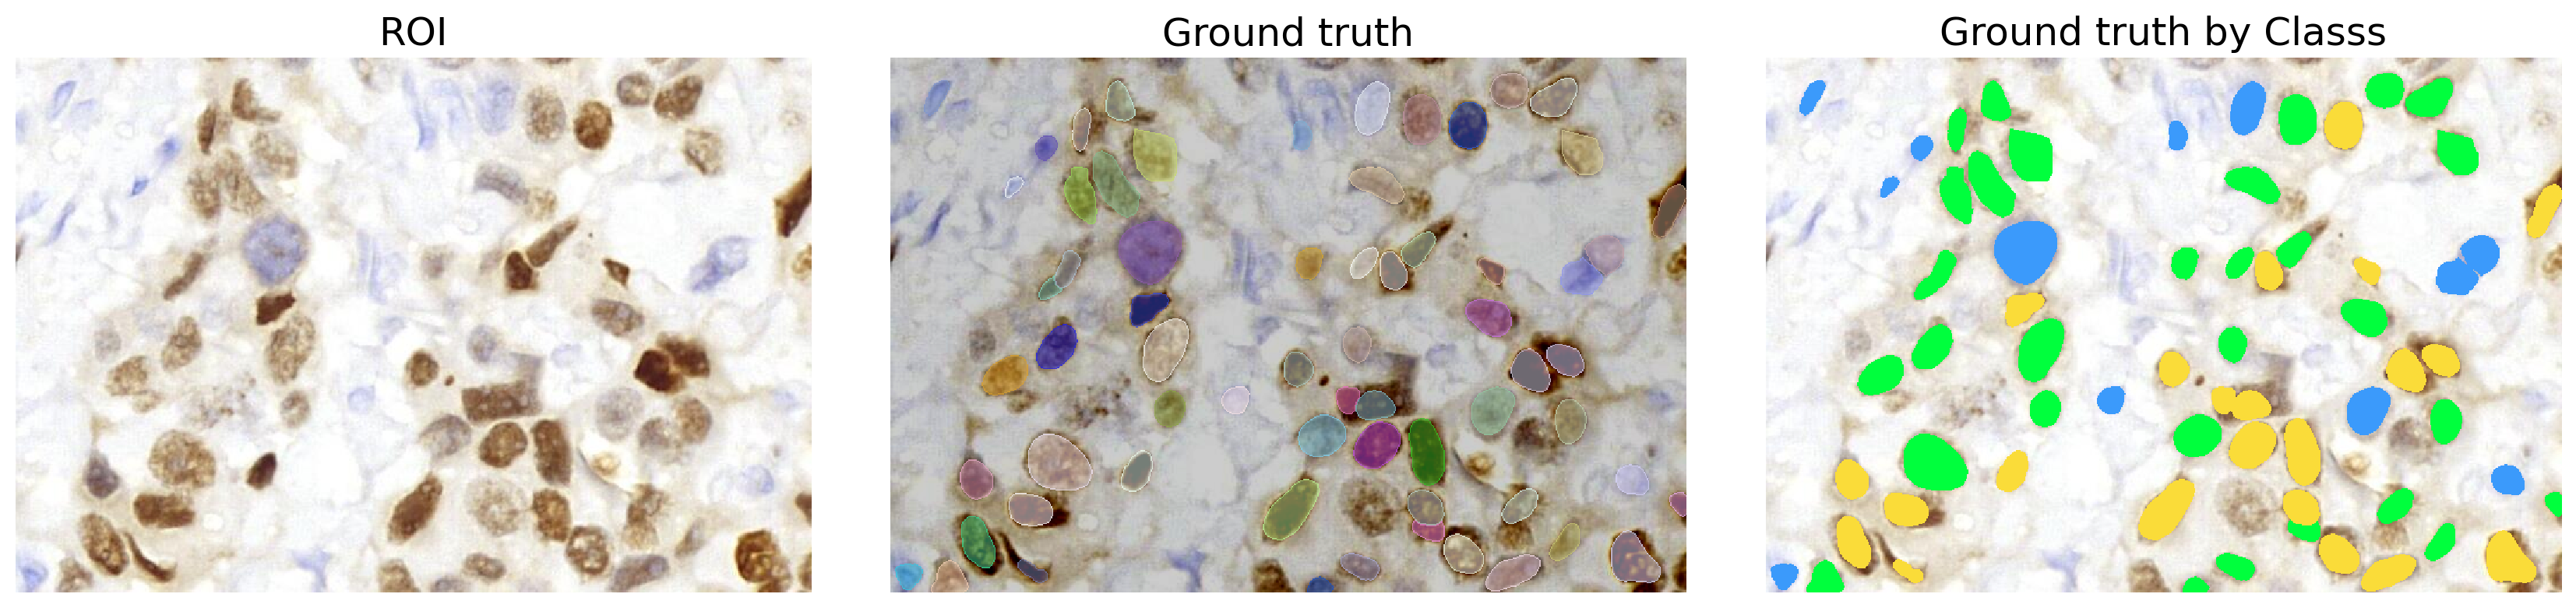

In [4]:
valuesss=24
plot_all(X_test[valuesss],Y_test[valuesss], C_test[valuesss])

In [5]:
model = StarDist2D(None, name='vggsegnet_multiclass_ai4dp', basedir='models')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    18496     
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                             

                                512)                                                              
                                                                                                  
 block4_conv3 (Conv2D)          (None, None, None,   2359808     ['block4_conv2[0][0]']           
                                512)                                                              
                                                                                                  
 block4_pool (MaxPooling2D)     (None, None, None,   0           ['block4_conv3[0][0]']           
                                512)                                                              
                                                                                                  
 conv2d_2 (Conv2D)              (None, None, None,   2359808     ['block4_pool[0][0]']            
                                512)                                                              
          

In [6]:
# model.optimize_thresholds(X_test, Y_test)

In [7]:
i = 42
label, res = model.predict_instances(X_test[i], n_tiles=model._guess_n_tiles(X_test[i]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 18ms/step



  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



 50%|█████     | 1/2 [00:01<00:01,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


In [8]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Predict'}>,
 <Axes: title={'center': 'Predict by Classs'}>)

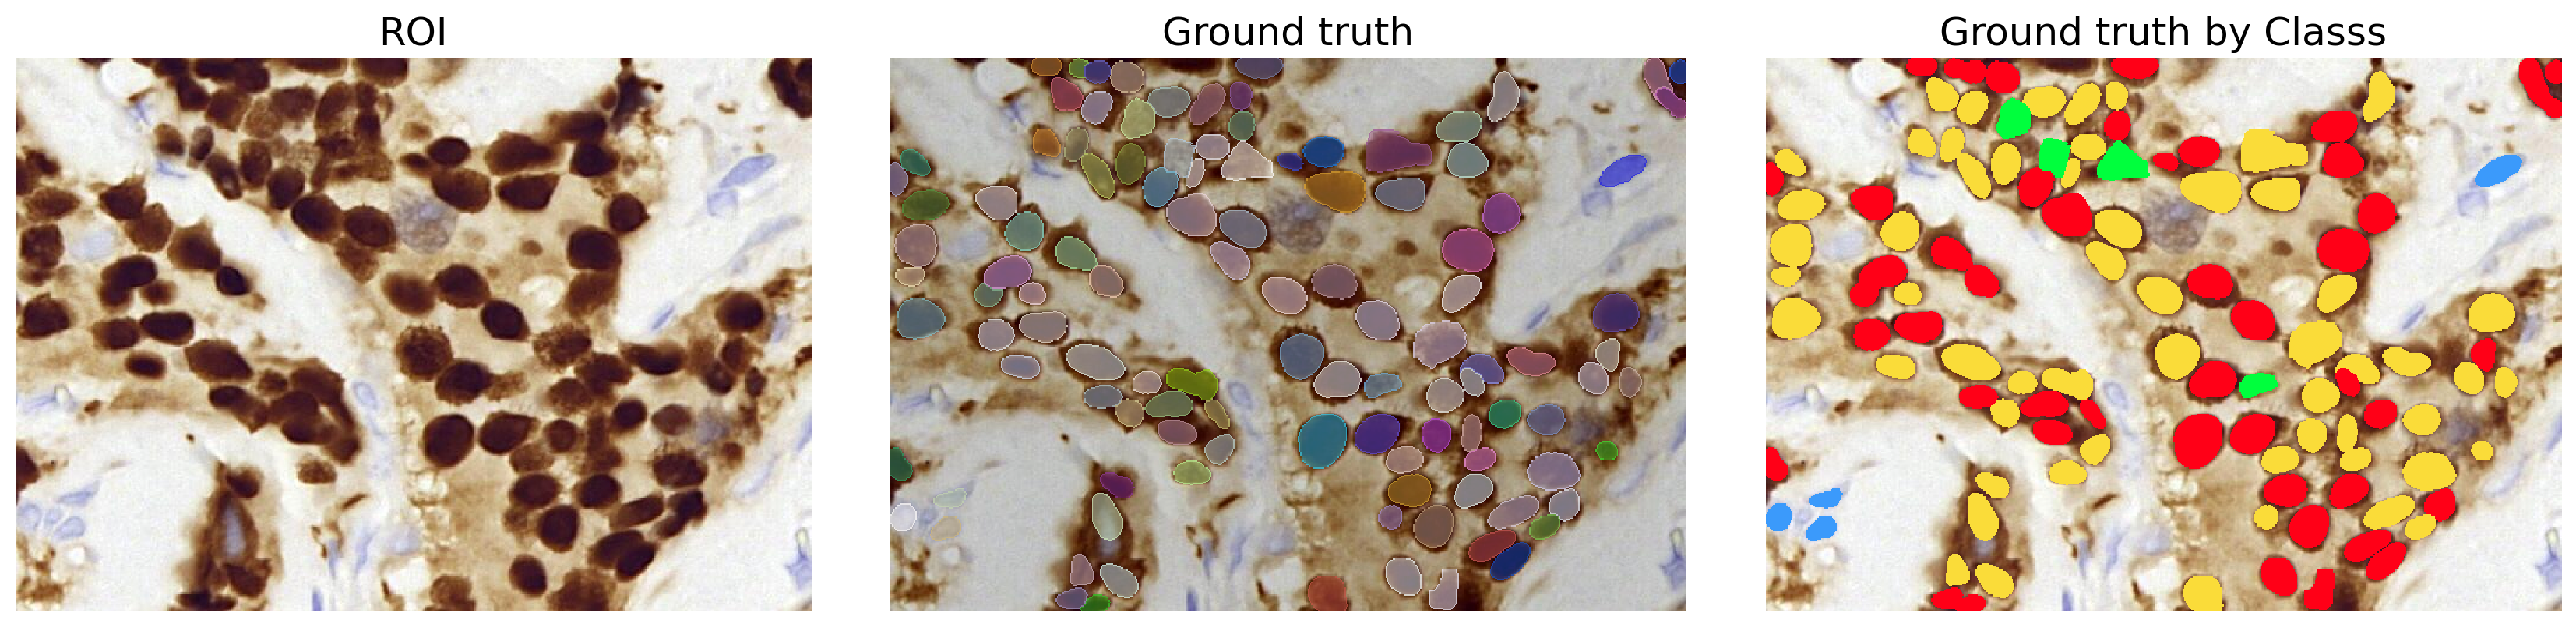

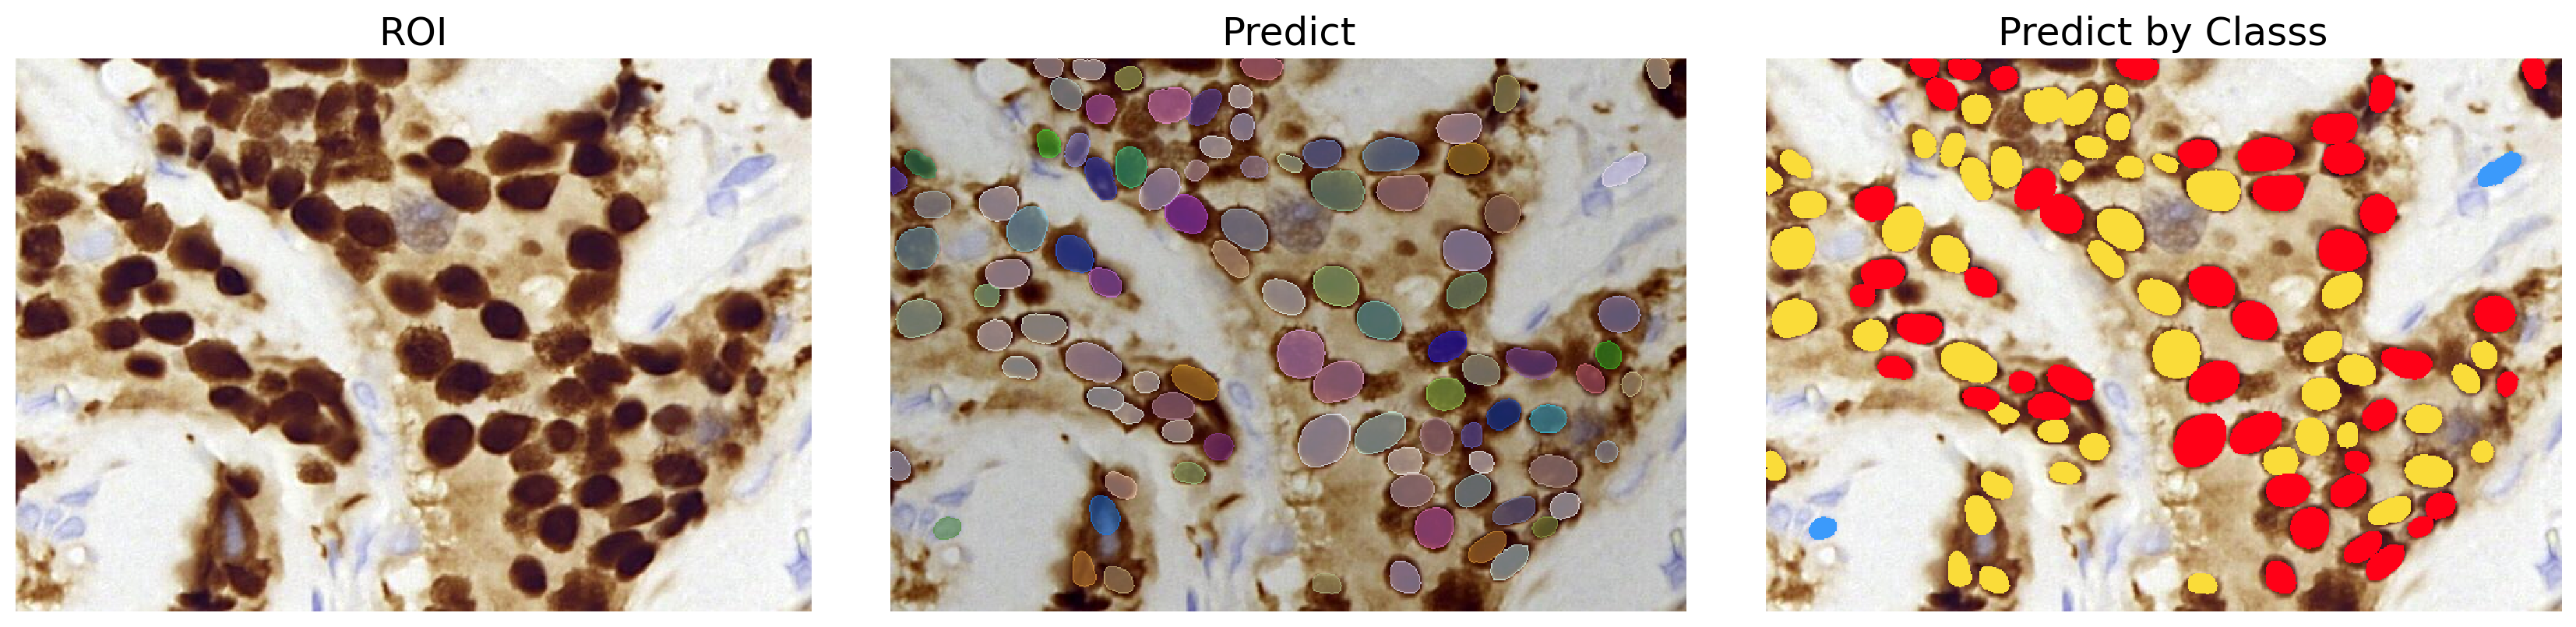

In [9]:
plot_all(X_test[i], Y_test[i], C_test[i],            lbl_title="Ground truth", cls_title="Ground truth by Classs")
plot_all(X_test[i], label,    class_from_res(res), lbl_title="Predict", cls_title="Predict by Classs")

In [10]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test[:])]))


  0%|          | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



  2%|▏         | 1/44 [00:01<01:18,  1.83s/it]

1/1 [==============================] - 0s 20ms/step



  5%|▍         | 2/44 [00:03<01:00,  1.44s/it]

1/1 [==============================] - 0s 20ms/step



  7%|▋         | 3/44 [00:04<01:05,  1.59s/it]

1/1 [==============================] - 0s 23ms/step



  9%|▉         | 4/44 [00:05<00:42,  1.06s/it]

1/1 [==============================] - 0s 19ms/step



 11%|█▏        | 5/44 [00:05<00:30,  1.27it/s]

1/1 [==============================] - 0s 20ms/step



 14%|█▎        | 6/44 [00:05<00:23,  1.64it/s]

1/1 [==============================] - 0s 19ms/step



 16%|█▌        | 7/44 [00:05<00:17,  2.06it/s]

1/1 [==============================] - 0s 21ms/step



 18%|█▊        | 8/44 [00:07<00:31,  1.13it/s]

1/1 [==============================] - 0s 19ms/step



 20%|██        | 9/44 [00:09<00:40,  1.16s/it]

1/1 [==============================] - 0s 19ms/step



 23%|██▎       | 10/44 [00:10<00:39,  1.16s/it]

1/1 [==============================] - 0s 19ms/step



 25%|██▌       | 11/44 [00:10<00:29,  1.12it/s]

1/1 [==============================] - 0s 19ms/step



 27%|██▋       | 12/44 [00:10<00:21,  1.46it/s]

1/1 [==============================] - 0s 20ms/step



 30%|██▉       | 13/44 [00:12<00:30,  1.00it/s]

1/1 [==============================] - 0s 19ms/step



 32%|███▏      | 14/44 [00:13<00:24,  1.25it/s]

1/1 [==============================] - 0s 21ms/step



 34%|███▍      | 15/44 [00:14<00:26,  1.10it/s]

1/1 [==============================] - 0s 20ms/step



 36%|███▋      | 16/44 [00:14<00:20,  1.35it/s]

1/1 [==============================] - 0s 20ms/step



 39%|███▊      | 17/44 [00:14<00:17,  1.58it/s]

1/1 [==============================] - 0s 20ms/step



 41%|████      | 18/44 [00:15<00:14,  1.79it/s]

1/1 [==============================] - 0s 19ms/step



 43%|████▎     | 19/44 [00:15<00:11,  2.13it/s]

1/1 [==============================] - 0s 20ms/step



 45%|████▌     | 20/44 [00:16<00:16,  1.46it/s]

1/1 [==============================] - 0s 18ms/step



 48%|████▊     | 21/44 [00:18<00:22,  1.02it/s]

1/1 [==============================] - 0s 19ms/step



 50%|█████     | 22/44 [00:19<00:25,  1.15s/it]

1/1 [==============================] - 0s 18ms/step



 52%|█████▏    | 23/44 [00:20<00:19,  1.08it/s]

1/1 [==============================] - 0s 19ms/step



 55%|█████▍    | 24/44 [00:22<00:22,  1.15s/it]

1/1 [==============================] - 0s 18ms/step



 57%|█████▋    | 25/44 [00:22<00:16,  1.15it/s]

1/1 [==============================] - 0s 20ms/step



 59%|█████▉    | 26/44 [00:24<00:20,  1.13s/it]

1/1 [==============================] - 0s 19ms/step



 61%|██████▏   | 27/44 [00:25<00:19,  1.16s/it]

1/1 [==============================] - 0s 21ms/step



 64%|██████▎   | 28/44 [00:27<00:21,  1.34s/it]

1/1 [==============================] - 0s 19ms/step



 66%|██████▌   | 29/44 [00:28<00:19,  1.30s/it]

1/1 [==============================] - 0s 20ms/step



 68%|██████▊   | 30/44 [00:29<00:20,  1.44s/it]

1/1 [==============================] - 0s 22ms/step



 70%|███████   | 31/44 [00:30<00:14,  1.08s/it]

1/1 [==============================] - 0s 18ms/step



 73%|███████▎  | 32/44 [00:31<00:13,  1.14s/it]

1/1 [==============================] - 0s 19ms/step



 75%|███████▌  | 33/44 [00:31<00:09,  1.16it/s]

1/1 [==============================] - 0s 18ms/step



 77%|███████▋  | 34/44 [00:32<00:07,  1.42it/s]

1/1 [==============================] - 0s 19ms/step



 80%|███████▉  | 35/44 [00:32<00:05,  1.64it/s]

1/1 [==============================] - 0s 18ms/step



 82%|████████▏ | 36/44 [00:32<00:03,  2.00it/s]

1/1 [==============================] - 0s 18ms/step



 84%|████████▍ | 37/44 [00:34<00:06,  1.12it/s]

1/1 [==============================] - 0s 19ms/step



 86%|████████▋ | 38/44 [00:36<00:06,  1.10s/it]

1/1 [==============================] - 0s 19ms/step



 89%|████████▊ | 39/44 [00:37<00:05,  1.17s/it]

1/1 [==============================] - 0s 19ms/step



 91%|█████████ | 40/44 [00:38<00:04,  1.15s/it]

1/1 [==============================] - 0s 20ms/step



 93%|█████████▎| 41/44 [00:40<00:03,  1.28s/it]

1/1 [==============================] - 0s 19ms/step



 95%|█████████▌| 42/44 [00:41<00:02,  1.39s/it]

1/1 [==============================] - 0s 20ms/step



 98%|█████████▊| 43/44 [00:41<00:01,  1.04s/it]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 44/44 [00:43<00:00,  1.01it/s]


In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


In [12]:
stats[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=395, tp=3669, fn=596, precision=0.9028051181102362, recall=0.8602579132473622, accuracy=0.7873390557939914, f1=0.8810181294273022, n_true=4265, n_pred=4064, mean_true_score=0.6585490965759349, mean_matched_score=0.7655251831279265, panoptic_quality=0.6744415648688588, by_image=False)

In [ ]:
for i in range(44):
    plot_all(X_test[i],Y_test[i],      C_test[i],                        lbl_title="Ground truth", cls_title="Ground truth by Classs")
    plot_all(X_test[i],Y_test_pred[i], class_from_res(res_test_pred[i]), lbl_title="Predict", cls_title="Predict by Classs");

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_f1=[]
all_recall=[]
all_pre=[]

for i in range(44):
    true_value = []
    predic_value = []
    for key, value in C_test[i].items():
        highlighted_image = np.zeros_like(Y_test[i])  # Create an image filled with zeros
        highlighted_image[Y_test[i] == key] = 1  # Set the pixels with the specific value to the value itself



        highlighted_image_2 = highlighted_image*Y_test_pred[i]
        flattened_matrix = highlighted_image_2.flatten()
        undesired_value = 0
        filtered_values = flattened_matrix[flattened_matrix != undesired_value]
        unique_values, counts = np.unique(filtered_values, return_counts=True)
        #highlighted_image_2[np.logical_and(highlighted_image, Y_test_pred[i]) == True] = value

        if len(counts) != 0:
            max_index = np.argmax(counts)

            true_value.append(value)
            predic_value.append(class_from_res(res_test_pred[i]).get(unique_values[max_index]))
            
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_value, predic_value, average='macro')
    recall = recall_score(true_value, predic_value, average='macro')
    f1 = f1_score(true_value, predic_value, average='macro')
    
    all_f1.append(f1)
    all_pre.append(precision)
    all_recall.append(recall)

    print(f"Image: {i}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 0
Precision: 0.5
Recall: 0.48863636363636365
F1 Score: 0.4942528735632184


Image: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 2
Precision: 0.5
Recall: 0.6616161616161617
F1 Score: 0.553011026293469


Image: 3
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 4
Precision: 0.5
Recall: 0.49740932642487046
F1 Score: 0.4987012987012987


Image: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 6
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 7
Precision: 0.5869467028003613
Recall: 0.5367589074485626
F1 Score: 0.5556110556110556


Image: 8
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 9
Precision: 0.5
Recall: 0.49107142857142855
F1 Score: 0.49549549549549543


Image: 10
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 11
Precision: 0.6014492753623188
Recall: 0.5162393162393162
F1 Score: 0.5401960784313725


Image: 12
Precision: 0.24757281553398058
Recall: 0.24757281553398058
F1 Score: 0.24757281553398058


Image: 13
Precision: 0.5677655677655677
Recall: 0.560233918128655
F1 Score: 0.5619047619047618


Image: 14
Precision: 0.865546218487395
Recall: 0.8222222222222222
F1 Score: 0.8359375


Image: 15
Precision: 0.5
Recall: 0.4880952380952381
F1 Score: 0.4939759036144578


Image: 16
Precision: 0.5
Recall: 0.49166666666666664
F1 Score: 0.49579831932773105


Image: 17
Precision: 0.6666666666666666
Recall: 0.6583333333333333
F1 Score: 0.6624472573839663




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 18
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 19
Precision: 0.5
Recall: 0.49606299212598426
F1 Score: 0.4980237154150198




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 20
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 21
Precision: 0.6619047619047619
Recall: 0.4906103286384977
F1 Score: 0.5484633569739953




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 22
Precision: 0.5
Recall: 0.4921259842519685
F1 Score: 0.49603174603174605


Image: 23
Precision: 0.6491361788617886
Recall: 0.6488988988988988
F1 Score: 0.6478129713423831


Image: 24
Precision: 0.6193181818181819
Recall: 0.5954545454545455
F1 Score: 0.6058897243107769




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 25
Precision: 0.6569444444444444
Recall: 0.6362179487179488
F1 Score: 0.631100082712986


Image: 26
Precision: 0.9234955185659411
Recall: 0.9283539899978256
F1 Score: 0.9257105943152455




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 27
Precision: 0.3869565217391305
Recall: 0.38
F1 Score: 0.38273211117681843


Image: 28
Precision: 0.5
Recall: 0.48360655737704916
F1 Score: 0.49166666666666664


Image: 29
Precision: 0.8614718614718614
Recall: 0.8518518518518517
F1 Score: 0.8561264822134387




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 30
Precision: 0.6481481481481481
Recall: 0.47135955831608006
F1 Score: 0.5215130023640662




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 31
Precision: 0.6224301632140615
Recall: 0.6224032761723298
F1 Score: 0.6177604735173347


Image: 32
Precision: 0.4764705882352941
Recall: 0.45922902494331064
F1 Score: 0.46409090909090905


Image: 33
Precision: 0.4838709677419355
Recall: 0.5
F1 Score: 0.4918032786885246


Image: 34
Precision: 0.7395833333333334
Recall: 0.6948882623224728
F1 Score: 0.7034980106100795


Image: 35
Precision: 0.5
Recall: 0.49404761904761907
F1 Score: 0.4970059880239521




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 36
Precision: 0.5858345358345358
Recall: 0.5577843694640136
F1 Score: 0.5660331384015594


Image: 37
Precision: 0.5
Recall: 0.483695652173913
F1 Score: 0.4917127071823204




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 38
Precision: 0.6621823617339312
Recall: 0.4136636636636637
F1 Score: 0.4629213483146068


Image: 39
Precision: 0.6557971014492754
Recall: 0.4093406593406594
F1 Score: 0.45755919854280513


Image: 40
Precision: 0.767989417989418
Recall: 0.745
F1 Score: 0.7461538461538462




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 41
Precision: 0.329004329004329
Recall: 0.3247863247863248
F1 Score: 0.3268817204301075


Image: 42
Precision: 0.6319444444444444
Recall: 0.6444444444444444
F1 Score: 0.6379928315412187


Image: 43
Precision: 0.49106753812636167
Recall: 0.4751515151515152
F1 Score: 0.473015873015873




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [16]:
import statistics

print(f"Precision: {statistics.mean(all_pre)}")
print(f"Recall: {statistics.mean(all_recall)}")
print(f"F1 Score: {statistics.mean(all_f1)}\n\n")

Precision: 0.656579491924488
Recall: 0.6308825719331299
F1 Score: 0.6358273673385701




In [17]:
# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score

all_aji_score=[]
for m in range(44):
    aji_score = get_fast_aji(Y_test[m],Y_test_pred[m])
    all_aji_score.append(aji_score)

print(all_aji_score)
print('Total AJI: ', (sum(all_aji_score) / len(all_aji_score)))

[0.6639080247198976, 0.6958627097338361, 0.6750476469725847, 0.6134473012712689, 0.6064923584176868, 0.603170759393091, 0.8273299790076972, 0.5668002454019763, 0.6109374330863775, 0.6518623086111413, 0.6968282956906373, 0.7370636647431653, 0.7121124978432162, 0.48204039744367216, 0.688653802324698, 0.737447171156756, 0.6360951599671862, 0.7089594184434369, 0.5994361553663585, 0.7069456481366844, 0.7857988165680473, 0.756933009439653, 0.6925817735944318, 0.6623197821916961, 0.5944709277298599, 0.5607114889808703, 0.7002325679732758, 0.5909880066252918, 0.6205820714432031, 0.6465161504529716, 0.6575178337726494, 0.6100337599120672, 0.5514482248941189, 0.5493006840660538, 0.6532494910001622, 0.7071904047976012, 0.5980037706554286, 0.6970379710204841, 0.6016095542433033, 0.6492175333792857, 0.574188966179942, 0.6825543994597255, 0.6745050832508969, 0.502254550852647]
Total AJI:  0.6486292681867053
